In [128]:
from models.maoea import MovieSelectionProblem, IntegerPolynomialMutation, IntegerSBX

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.sampling.rnd import IntegerRandomSampling

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from collections import defaultdict

In [4]:
ratings_df = pd.read_csv('datasets/ml-latest-small/ratings.csv', encoding='latin-1')

In [5]:
model = DCN()
model.fit(ratings_df)

In [135]:
def get_user_info(user_id):

    all_movies = ratings_df['movieId'].unique()
    movies_rated = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    
    # Movies not rated by the user
    movies_not_rated = set(all_movies) - set(movies_rated)
    
    # Convert to a list
    candidates = list(movies_not_rated)
    
    predictions = {}
    for movie_id in candidates:
        predictions[movie_id] = model._predict_single(user_id, movie_id)
    df = pd.DataFrame(list(predictions.items()), columns=['movieId', 'predictedRating'])
    df = df.sort_values(by='predictedRating', ascending=False)
    return df

    rating_counts = ratings_df['movieId'].value_counts()

    # Create a DataFrame with movieId and novelty indicator (1 if novel, 0 otherwise)
    novelty_df = pd.DataFrame({
        'is_novel': (rating_counts < 16).astype(int)
    })
    user_info = pd.merge(df, novelty_df, on='movieId', how='left')
    user_info = pd.merge(user_info, rating_counts, on='movieId', how='left')
    return user_info

In [136]:
user_info = get_user_info(1)

In [80]:
pivot = ratings_df.pivot(index='movieId',columns='userId', values='rating').fillna(0)
item_similarity = cosine_similarity(pivot)

In [146]:
def run(final_df, user_info):
    problem = MovieSelectionProblem(ratings_df, user_info.head(200))
    
    algorithm = NSGA2(pop_size=100, sampling=IntegerRandomSampling(),
                     mutation=IntegerPolynomialMutation(),
                     crossover=IntegerSBX(eta=15, prob=0.9))
    
    termination = get_termination("n_gen", 100)
    
    res = minimize(problem, algorithm, termination, seed=1,
                   save_history=True, verbose=True)
    
    print("Optimal selection of movies indices:\n", res.X)
    print("Objective values:\n", -res.F)
    
    weights = [1, 4, 2, 2]
    weighted_sums = []
    
    for i in range(len(res.F)):
        weighted_sum = sum(weights[j] * (-res.F[i][j]) for j in range(len(weights)))
        weighted_sums.append(weighted_sum)
    
    # Get the index of the best weighted sum
    best_solution_index = weighted_sums.index(max(weighted_sums))
    print("Chosen optimal selection of movies indices:\n", res.X[best_solution_index])
    print("Corresponding objective values:\n", -res.F[best_solution_index])
    return (res.X[best_solution_index], -res.F[best_solution_index])

In [ ]:
results = {} #YAY
def do_it(user):
    user_id = user

    # List of all unique movie IDs
    all_movies = ratings_df['movieId'].unique()
    
    # Movies rated by the user
    movies_rated = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    
    # Movies not rated by the user
    movies_not_rated = set(all_movies) - set(movies_rated)
    
    # Convert to a list (optional)
    candidates = list(movies_not_rated)
    
    predictions = {}
    for movie_id in candidates:
        predictions[movie_id] = model._predict_single(user_id, movie_id)
    df = pd.DataFrame(list(predictions.items()), columns=['movieId', 'predictedRating'])
    df = df.sort_values(by='predictedRating', ascending=False)
    
    rating_counts = ratings_df['movieId'].value_counts()
    
    # Create a DataFrame with movieId and novelty indicator (1 if novel, 0 otherwise)
    novelty_df = pd.DataFrame({
        'is_novel': (rating_counts < 16).astype(int)
    })
    
    # need this
    user_info = pd.merge(df, novelty_df, on='movieId', how='left')
    user_info = pd.merge(user_info, rating_counts, on='movieId', how='left')

    movie_idx, metrics = run(ratings_df, user_info)
    movieIds = user_info.iloc[movie_idx]['movieId']
    results[user] = (movieIds, metrics)
    
for i in np.random.choice(np.arange(0, 611), size=100, replace=False):
    do_it(i)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     26 |  0.000000E+00 |  0.1500000000 |             - |             -
     2 |      200 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0157232704 |         ideal
     3 |      300 |     39 |  0.000000E+00 |  0.000000E+00 |  0.1342347108 |         ideal
     4 |      400 |     48 |  0.000000E+00 |  0.000000E+00 |  0.1428571429 |         ideal
     5 |      500 |     54 |  0.000000E+00 |  0.000000E+00 |  0.0594189345 |         nadir
     6 |      600 |     68 |  0.000000E+00 |  0.000000E+00 |  0.0161899179 |         ideal
     7 |      700 |     71 |  0.000000E+00 |  0.000000E+00 |  0.2251280471 |         ideal
     8 |      800 |     78 |  0.000000E+00 |  0.000000E+00 |  0.0567023313 |         ideal
     9 |      900 |     75 |  0.000000E+00 |  0.000000E+00 |  0.0590766534 |         ideal
    10 |     1000 |     85 |  0.000000E+00 |  0.000000E+00 |  0.0353992835 |         ideal

In [134]:
run(ratings_df, user_info)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     25 |  0.000000E+00 |  0.1500000000 |             - |             -
     2 |      200 |     32 |  0.000000E+00 |  0.000000E+00 |  0.1890117633 |         ideal
     3 |      300 |     39 |  0.000000E+00 |  0.000000E+00 |  0.1324375850 |         ideal
     4 |      400 |     61 |  0.000000E+00 |  0.000000E+00 |  0.0242424242 |         ideal
     5 |      500 |     63 |  0.000000E+00 |  0.000000E+00 |  0.1428571429 |         nadir
     6 |      600 |     71 |  0.000000E+00 |  0.000000E+00 |  0.0803571429 |         ideal
     7 |      700 |     69 |  0.000000E+00 |  0.000000E+00 |  0.0756840866 |         ideal
     8 |      800 |     67 |  0.000000E+00 |  0.000000E+00 |  0.1302779585 |         nadir
     9 |      900 |     71 |  0.000000E+00 |  0.000000E+00 |  0.0801162113 |         nadir
    10 |     1000 |     67 |  0.000000E+00 |  0.000000E+00 |  0.0431202734 |             f

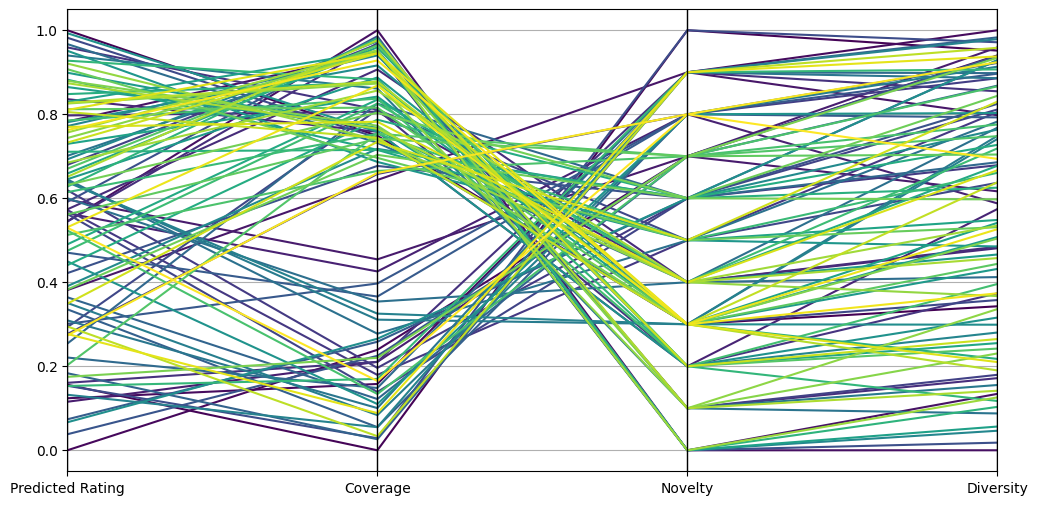

In [120]:
from sklearn.preprocessing import MinMaxScaler

data = -res.F

df = pd.DataFrame(data, columns=["Predicted Rating", "Coverage", "Novelty", "Diversity"])

# Normalize data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Add an 'ID' column for unique identifiers
df_scaled['ID'] = df_scaled.index.astype(str)

# Plot Parallel Coordinates Plot without class_column
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_scaled, class_column='ID', color=plt.cm.viridis(np.linspace(0, 1, len(df_scaled))))
plt.legend().remove()
# Save and show plot
plt.show()

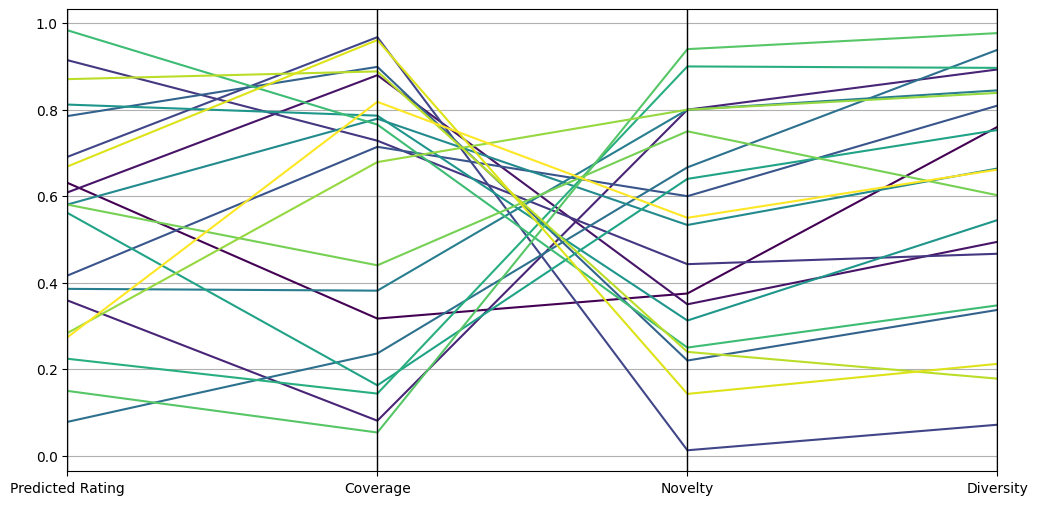

In [122]:
from sklearn.cluster import KMeans

data = -res.F

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Predicted Rating", "Coverage", "Novelty", "Diversity"])

# Normalize data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Determine the number of clusters
n_clusters = 20

# Applying KMeans Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

# Getting the cluster centers (centroids)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)

# Plot Parallel Coordinates Plot for centroids
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(centroids.assign(ClusterID=centroids.index.astype(str)), class_column='ClusterID', color=plt.cm.viridis(np.linspace(0, 1, n_clusters)))

plt.legend().remove()
plt.show()